In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# Scikit Imports
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import vgg16 as vgg

from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.15,
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

In [6]:
# One hot encode the class values
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(y_train, 10)
Y_val = to_categorical(y_val, 10)
Y_test = to_categorical(y_test, 10)

In [7]:
# Loading the vgg16 as the base model
base_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(32,32, 3),classes=10)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [9]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
pred = Dense(10, activation='softmax')(x)
model = Model(base_model.input, pred)

In [10]:
# Freezing the base model parameters
for layer in base_model.layers:
     layer.trainable = False

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [13]:
# Data Augmentation
BATCH_SIZE = 100

train_datagen = ImageDataGenerator(rescale=1/255, horizontal_flip=False)
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,Y_train,batch_size=BATCH_SIZE)

val_datagen = ImageDataGenerator(rescale=1/255,horizontal_flip=False)
val_datagen.fit(X_test)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=BATCH_SIZE)

In [14]:
# Training the model for a few epochs
EPOCHS = 10

In [15]:
train_steps_per_epoch = X_train.shape[0] / BATCH_SIZE
val_steps_per_epoch = X_test.shape[0] / BATCH_SIZE

In [16]:
# Train model without training the base model parameters
model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
425/425 [==============================] - 12s 28ms/step - loss: 0.1807 - acc: 0.9299 - val_loss: 0.1458 - val_acc: 0.9419
Epoch 2/10
425/425 [==============================] - 9s 21ms/step - loss: 0.1428 - acc: 0.9441 - val_loss: 0.1334 - val_acc: 0.9476 0s - loss: 0.1431 - acc: 0
Epoch 3/10
425/425 [==============================] - 11s 26ms/step - loss: 0.1302 - acc: 0.9491 - val_loss: 0.1303 - val_acc: 0.9476
Epoch 4/10
425/425 [==============================] - 9s 21ms/step - loss: 0.1217 - acc: 0.9523 - val_loss: 0.1249 - val_acc: 0.9506A: 2s - loss: 0.1214 - acc:  - 
Epoch 5/10
425/425 [==============================] - 9s 21ms/step - loss: 0.1154 - acc: 0.9549 - val_loss: 0.1230 - val_acc: 0.9526
Epoch 6/10
425/425 [==============================] - 9s 21ms/step - loss: 0.1092 - acc: 0.9572 - val_loss: 0.1236 - val_acc: 0.9527
Epoch 7/10
425/425 [============================

In [17]:
metrics = pd.DataFrame(model.history.history)

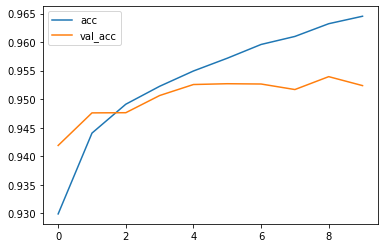

In [18]:
metrics[['acc','val_acc']].plot()

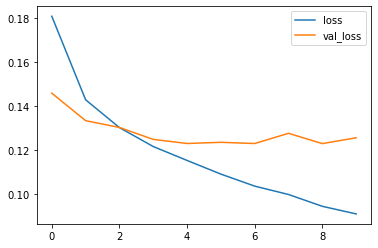

In [19]:
metrics[['loss','val_loss']].plot()

In [20]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
predictions = model.predict(X_test/255)
accuracy_score(y_test,np.argmax(predictions,axis=1))

0.7378

In [21]:
#Fine-Tuning The base model parameters
for layer in base_model.layers:
     layer.trainable = True

In [22]:
#Compile with a low learning rate
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [24]:
# Preventing overfitting by monitoring the val_loss metric
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [25]:
EPOCHS=20
model.fit_generator(train_generator,
                              callbacks=[early_stop],
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/20
425/425 [==============================] - 23s 54ms/step - loss: 0.0853 - acc: 0.9666 - val_loss: 0.1292 - val_acc: 0.9517ss: 0.08 - ETA: 4s - loss: 0.0866 - ac - ETA: 4s  - ETA: 1s - loss: 0.0854 - ac - ETA: 0s - loss: 0.0853 - acc: 
Epoch 2/20
425/425 [==============================] - 21s 50ms/step - loss: 0.0673 - acc: 0.9740 - val_loss: 0.1562 - val_acc: 0.9449
Epoch 3/20
425/425 [==============================] - 21s 50ms/step - loss: 0.0586 - acc: 0.9774 - val_loss: 0.1299 - val_acc: 0.9539: 7s - loss: 0.0576 - acc: 0.97  - ETA: 3s - loss: 0.0581 - acc: - ETA:
Epoch 4/20
425/425 [==============================] - 21s 50ms/step - loss: 0.0502 - acc: 0.9808 - val_loss: 0.1151 - val_acc: 0.9597TA: 15s - loss: 0. - ETA: 14s - loss: 0.0475 - acc: 0.98 - ETA: 14s - loss:  - ETA: 13s - loss - ETA: 12s - loss: 0.0483 - a - ETA: 12s - loss: 0.0482 - a - ETA: 11s - lo -  - ETA: 1s - loss: 0.049
Epoch 5/20
425/425 [==============================] - 21s 50ms/step - loss: 0.0434 -

In [26]:
metrics

,loss,acc,val_loss,val_acc
0,0.180707,0.929891,0.145834,0.94189
1,0.142845,0.944057,0.133390,0.94760
2,0.130240,0.949117,0.130302,0.94763
3,0.121659,0.952259,0.124899,0.95064
4,0.115358,0.954941,0.123043,0.95257
5,0.109166,0.957178,0.123575,0.95271
6,0.103721,0.959591,0.123031,0.95266
7,0.099924,0.960998,0.127656,0.95169
8,0.094569,0.963228,0.122987,0.95395
9,0.091125,0.964537,0.125637,0.95238


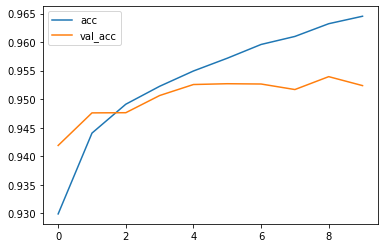

In [27]:
metrics[['acc','val_acc']].plot()

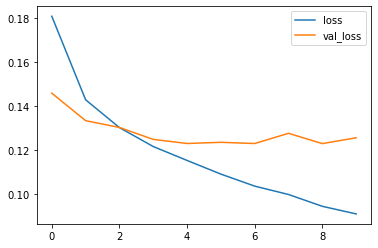

In [28]:
metrics[['loss','val_loss']].plot()

In [29]:
model.evaluate(X_test,Y_test)

10000/10000 [==============================] - 2s 219us/sample - loss: 1.9034 - acc: 0.8740


[1.9033796401977539, 0.8740001]

In [30]:
predictions = model.predict(X_test/255)

In [31]:
accuracy_score(y_test,np.argmax(predictions,axis=1))

0.8031

In [32]:
print(classification_report(y_test,np.argmax(predictions,axis=1)))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1000
           1       0.96      0.76      0.85      1000
           2       0.77      0.77      0.77      1000
           3       0.63      0.71      0.67      1000
           4       0.78      0.80      0.79      1000
           5       0.76      0.68      0.72      1000
           6       0.83      0.86      0.85      1000
           7       0.83      0.86      0.84      1000
           8       0.94      0.86      0.90      1000
           9       0.74      0.93      0.83      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



In [33]:
confusion_matrix(y_test,np.argmax(predictions,axis=1))

array([[799,   6,  44,  21,  18,   7,   8,  22,  24,  51],
       [ 19, 758,   1,  12,   2,   4,  13,  10,  13, 168],
       [ 22,   0, 766,  51,  61,  26,  42,  24,   3,   5],
       [  4,   1,  52, 711,  45,  92,  53,  22,   3,  17],
       [  4,   1,  34,  42, 797,  32,  32,  52,   1,   5],
       [  4,   0,  29, 198,  26, 683,  18,  29,   1,  12],
       [  5,   0,  40,  42,  23,  12, 863,   4,   6,   5],
       [  3,   0,  19,  27,  34,  43,   0, 859,   0,  15],
       [ 47,   6,   6,  18,   9,   0,   5,   4, 863,  42],
       [  6,  19,   6,  10,   3,   3,   4,  10,   7, 932]], dtype=int64)

In [34]:
# TESTING THE MODEL 
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

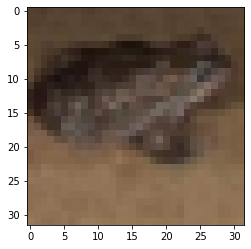

In [87]:
import random
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#image is the index of an image in the test set.
image = random.randint(0,9999)

my_image = x_test[image]
plt.imshow(my_image)

In [88]:
# Reshape to pass to our model
my_image = my_image.reshape(1,32,32,3)

# Making a prediction
Predicted=label_dict[np.argmax(model.predict(my_image/255))]
Actual=label_dict[y_test[image][0]]
print('Actual:',Actual)
print('Predicted:',Predicted)

Actual: frog
Predicted: frog
